In [ ]:
# Dataloading Stuff
from google.colab import drive
import sys
import os
import operator
import collections
from importlib import reload


# Standard Stuff
!pip3 install numpy sklearn iterative-stratification pandas pyss3
from sklearn.model_selection import train_test_split
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pyss3 import SS3
from pyss3.util import Dataset, Evaluation, span

import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import pandas as pd

!pip3 install nltk
from nltk import word_tokenize, sent_tokenize, download
download('punkt')

drive.mount('/content/drive', force_remount=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Mounted at /content/drive


In [ ]:
!rm -rf vocab_beer
!mkdir vocab_beer

In [ ]:
path_root = '/content/drive/My Drive/NLP Lab/SingleLabel'
vocab_root = '/Notebooks/Experiments/word-cloud/vocab_beer'
sys.path.append(path_root)
data_root = '/data/'

In [ ]:
import util

In [ ]:
with open(path_root + data_root + 'BeerReview/test.txt', 'r') as text_file:
  text = text_file.read().split('\n')

with open(path_root + data_root + 'BeerReview/test_label.txt', 'r') as label_file:
  labels = label_file.read().split('\n')
del text[-1]
del labels[-1]
X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.2)

In [ ]:
def rename_labels(gold):
    for i,label in enumerate(gold):
        gold[i] = label.split()[0]
#     return temp


def avg_important_word_number(samples, labels, vocab, threshold):
    size = 0
    for i, sample in enumerate(samples):
        
        # if(i%1000==0):
        #     print(i)
            
        df = vocab[labels[i] + '_' + 'words']
        for word in word_tokenize(sample):
            try:
                if df[df.term == word].iloc[0,3] > threshold:
                    size += 1
            except IndexError:
                    size += 0 
    return size / len(samples)

def __false_negative_words__(clf, categories, X_val, y_val, vocab):
    
    ## clf: model
    ## categories: list of classses
    ## X_val
    ## y_val
    ## vocab: dict of cat as keys and dataframe as vocab learned by the model for that class
    
    ## return
    ## fn_word: dict with keys as class and values as FN and word
    ##          FN: dict with keys as fals negative classes and all sentences and important words as keys
    ##          word: df of all fn_words with their gv and fn_class
    
    predict = clf.predict(X_val)
    fn_word = {}
    for cat in categories:
        class_vocab = vocab[cat+ "_words"].set_index('term', inplace=False)
        FN = collections.defaultdict(list)
        word = []
        for i, label in enumerate(y_val):
            if label == cat and predict[i] != cat:
                sentence = X_val[i].split()
                top_words = clf.extract_insight(X_val[i], predict[i],window_size=0)
                FN_word_sentence = []
                for top_word in list(set(top_words)):
                    insert = [X_val[i]]
                    insert.extend([top_word[0], top_word[1], predict[i], sentence.count(top_word[0])])
                    try:
                        insert.append(class_vocab.loc[top_word[0], 'gv'])
                    except KeyError:
                        insert.append("word not in vocab of "+ cat)
                    word.append(insert)
                    FN_word_sentence.append(insert)
                FN[predict[i]].append(FN_word_sentence)
        fn_word[cat] = (dict(FN),pd.DataFrame(word, columns =['sentence', 'fn_word', 'gv', 'fn_class', 'count', 'gv_trueclass']))
    return fn_word
    

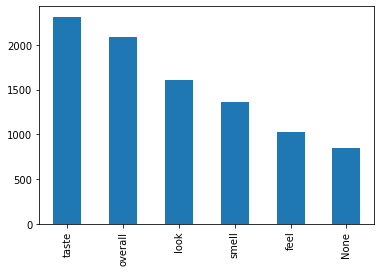

In [ ]:
pd.Series(labels).value_counts().plot(kind ='bar')

Training on 'taste': 100%|██████████| 6/6 [00:00<00:00, 21.54it/s]



              precision    recall  f1-score   support

        None       0.69      0.53      0.60       152
        feel       0.85      0.80      0.82       198
        look       0.99      0.86      0.92       330
     overall       0.70      0.80      0.75       450
       smell       0.70      0.88      0.78       256
       taste       0.76      0.69      0.73       462

    accuracy                           0.77      1848
   macro avg       0.78      0.76      0.77      1848
weighted avg       0.78      0.77      0.77      1848


 Accuracy: 0.773



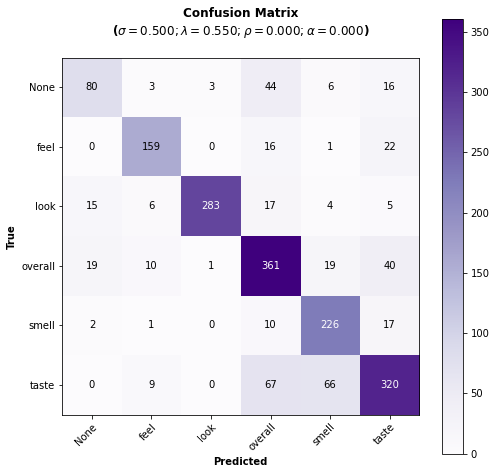

0.7656680218754938

In [ ]:
clf = SS3(s=0.5, l=0.55, p=0.0, a=0)
clf.fit(X_train, y_train)
Evaluation.test(clf, X_val, y_val, metric="f1-score")

In [ ]:
clf.print_categories_info()
clf.save_vocab(path='./vocab_beer')



 CATEGORIES:

	Category | Index |   Length   | Vocab. Size | Word Max. Fr. | N-gram |
	---------|-------|------------|-------------|---------------|--------|
	  None   |   0   |    3931    |    1444     |      169      |   1    |
	  feel   |   1   |    4667    |     992     |      240      |   1    |
	  look   |   2   |    9916    |    1511     |      758      |   1    |
	overall  |   3   |   10618    |    2519     |      409      |   1    |
	 smell   |   4   |    7184    |    1449     |      287      |   1    |
	 taste   |   5   |   12937    |    2338     |      470      |   1    |

	Most Probable Category: taste (26.27%)



In [ ]:
vocab = {}
categories = list(set(labels))
grams = ["words"]
for gram in grams:
  for cat in categories:
    vocab[cat + '_' + gram] = pd.read_csv("/content/vocab_beer/ss3_vocab_"+ cat +"(" + gram + ").csv")

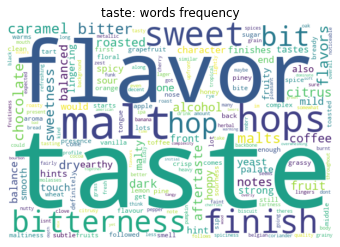

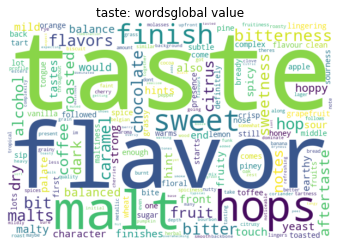

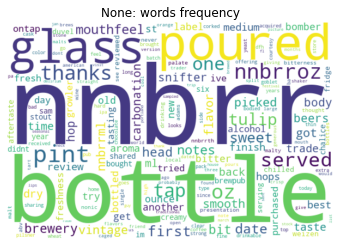

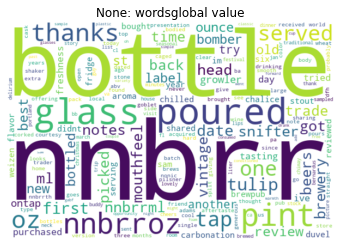

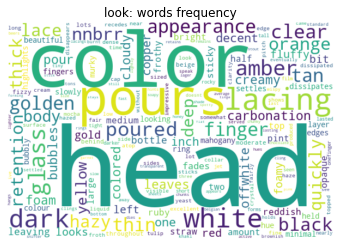

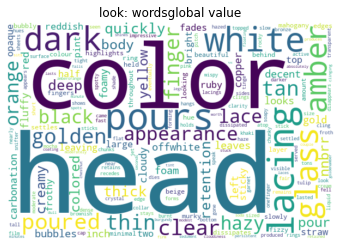

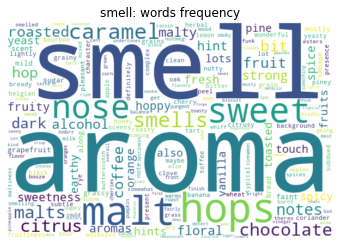

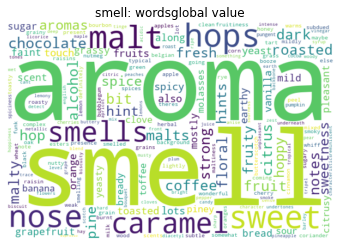

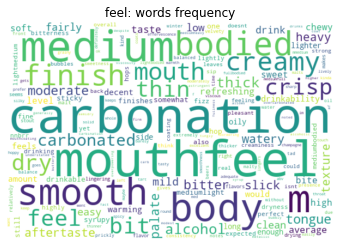

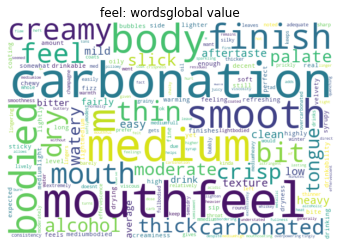

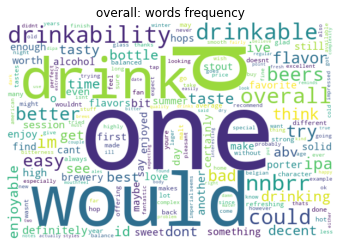

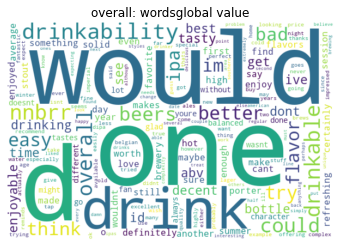

In [ ]:
for cat in categories:
    for gram in ["words"]:
        for col in ["fr", "gv"]:
            df = vocab[cat + '_' + gram]
            df1 = df[["term",col]]
            count = df1.set_index('term').T.to_dict('records')[0]

            wordcloud = WordCloud(height =400,width = 600,max_font_size = 200,background_color="white").generate_from_frequencies(count)
            plt.figure()
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.title(cat + ": " + gram + " frequency") if col == "fr" else plt.title(cat + ": " + gram + "global value")
            plt.axis("off")
            plt.show()

In [ ]:
for cat in categories:
  for gram in ["words"]:
    df = vocab[cat + '_' + gram]
    above_threshold = df[df.gv > 0.2].count()["term"]
    total = df.describe()["fr"]["count"]
    percentage = (above_threshold/total)*100
    print(cat,"_", gram ,":         percentage=", round(percentage,2),", above threshold=", above_threshold,", total=", total)
  print("            ")  
  

taste _ words :         percentage= 9.66 , above threshold= 102 , total= 1056.0
            
None _ words :         percentage= 11.76 , above threshold= 60 , total= 510.0
            
look _ words :         percentage= 7.08 , above threshold= 45 , total= 636.0
            
smell _ words :         percentage= 14.14 , above threshold= 84 , total= 594.0
            
feel _ words :         percentage= 14.51 , above threshold= 55 , total= 379.0
            
overall _ words :         percentage= 7.05 , above threshold= 78 , total= 1106.0
            


In [ ]:
# important_words = avg_important_word_number(X_train, y_train, vocab, 0.2)

In [ ]:
# words = util.avg_word_number(X_train, y_train)

In [ ]:
# print("percentage of average important words per sample: ", (important_words/words)*100)

In [ ]:
fn_word = __false_negative_words__(clf, categories, X_val, y_val, vocab)

Classification: 100%|██████████| 1848/1848 [00:00<00:00, 56465.90it/s]


In [ ]:
true_class = 'smell'
fn_class = 'taste'
## word frequency in false_negative class ##
a = fn_word[true_class][1]
b = a[a.fn_class == fn_class].groupby(['fn_word','fn_class'], as_index=False).agg({'count': sum}).sort_values('count', ascending=False)
b

,fn_word,fn_class,count
41,malt,taste,5
11,bit,taste,4
4,also,taste,3
65,sweetness,taste,3
60,spiciness,taste,2
...,...,...,...
34,isnt,taste,1
35,kind,taste,1
1,added,taste,1
37,lemon,taste,1


In [ ]:
a[a.fn_class == fn_class].sentence.unique()

array(['biscuity rye adds spiciness',
       'tiny bit bitterness earthy flare lying underneath majority one hands rich brewed coffee',
       'reminds bit banana runts', 'loaded spiciness breadiness malt',
       'also get hints dough sweet malt dominant', 'terribly appealing',
       'getting hints cat piss',
       'caramelized sugar licorise lend bit sweetness things',
       'nose sour red fruit hops mouthfeel thick taste follow scents nose alcohol added midglass',
       'im also getting touch sourness isnt infected acidity roast',
       'heavy pumpkin pie thick scone malt notes overlaying spicy sweetness balances pumpkin pie notes',
       'sulphur character comes doubt heavy fermentation lager yeast blends rather smoothly pleasantly smoke dark characters give complete picture',
       'oaky wood galore',
       'classic belgian yeast must refreshing wintergreen lends almost physical coolness also perceived clean lemon',
       'kind like root beer splash coffee',
       'tropi

In [ ]:
a[(a.sentence == 'phenols red berries malt fudge sweetness')].sort_values('gv', ascending=False)

,sentence,fn_word,gv,fn_class,count,gv_trueclass
154,phenols red berries malt fudge sweetness,malt,0.730782,taste,1,0.722944
155,phenols red berries malt fudge sweetness,sweetness,0.456630,taste,1,0.354167
156,phenols red berries malt fudge sweetness,red,0.117376,taste,1,1e-06
153,phenols red berries malt fudge sweetness,phenols,0.065176,taste,1,0.083476


In [ ]:
c = b[['fn_word','count']].set_index('fn_word', inplace=False)
true_vocab = vocab[true_class + '_words'].sort_values('gv', ascending=False).set_index('term', inplace=False)
false_vocab = vocab[fn_class + '_words'].sort_values('gv', ascending=False).set_index('term', inplace=False)

result = pd.concat([c, false_vocab, true_vocab], axis=1, sort=False)

In [ ]:
result.columns = ['count', fn_class +'_fr', fn_class +'_gv', fn_class +'_cv', true_class +'_fr', true_class +'_gv', true_class +'_cv']
result[(~result['count'].isnull()) & (result[fn_class +'_gv'] > result[true_class + '_gv'])]
# result[~result['count'].isnull()]

,count,taste_fr,taste_gv,taste_cv,smell_fr,smell_gv,smell_cv
malt,5.0,251.0,0.730782,0.730782,150.0,0.722944,0.722944
bit,4.0,133.0,0.531957,0.531957,68.0,0.486758,0.486758
sweetness,3.0,98.0,0.456630,0.456630,36.0,0.354167,0.354167
spiciness,2.0,20.0,0.206284,0.206284,8.0,0.166957,0.166957
heavy,2.0,14.0,0.166204,0.166204,4.0,0.000292,0.000292
pie,2.0,5.0,0.103142,0.103142,2.0,0.083476,0.083476
getting,2.0,10.0,0.145641,0.145641,2.0,0.000206,0.000206
red,2.0,10.0,0.117376,0.117376,2.0,0.000001,0.000001
comes,2.0,22.0,0.216353,0.216353,5.0,0.020129,0.020129
sourness,1.0,20.0,0.206284,0.206284,5.0,0.131991,0.131991


In [ ]:
result[(~result['count'].isnull()) & (result[true_class + '_gv'].isnull())]

,count,taste_fr,taste_gv,taste_cv,smell_fr,smell_gv,smell_cv
minty,1.0,4.0,0.092253,0.092253,NaN,NaN,NaN
oaky,1.0,3.0,0.079890,0.079890,NaN,NaN,NaN
things,1.0,8.0,0.130466,0.130466,NaN,NaN,NaN
splash,1.0,2.0,0.065176,0.065176,NaN,NaN,NaN
acidity,1.0,5.0,0.103142,0.103142,NaN,NaN,NaN
lends,1.0,2.0,0.065176,0.065176,NaN,NaN,NaN
complete,1.0,4.0,0.092253,0.092253,NaN,NaN,NaN
adds,1.0,10.0,0.145865,0.145865,NaN,NaN,NaN
appealing,1.0,2.0,0.065176,0.065176,NaN,NaN,NaN
balances,1.0,3.0,0.079890,0.079890,NaN,NaN,NaN


In [ ]:
true_vocab.head(20)

,fr,gv,cv
term,,,
aroma,287,1.000000,1.000000
smell,239,0.912553,0.912553
hops,159,0.744316,0.744316
malt,150,0.722944,0.722944
sweet,147,0.715678,0.715678
nose,134,0.683300,0.683300
caramel,100,0.590281,0.590281
chocolate,91,0.563093,0.563093
smells,91,0.563093,0.563093


In [ ]:
!rm -rf vocab_beer

**ALL METRICS**

In [ ]:
# ### from all metrics notebook ###

# !rm -rf vocab && mkdir vocab
# util = reload(util)
# print("Avg Number of Sentences", util.avg_sent_number(X_train, y_train))
# print("Avg Number of Paragraphs", util.avg_para_number(X_train, y_train))
# overlap, counter, ratio = util.calc_overlap(clf, './vocab', 'fr')
# print("Overlap Ratio All Words", ratio)

# !rm -rf vocab_five && mkdir vocab_five
# overlap, counter, ratio = util.calc_overlap(clf, './vocab', 'gv', True, 0.2)
# print("Overlap Ratio Important Words", ratio)

Avg Number of Words 6.687195452084461
Avg Number of Sentences 1.0
Avg Number of Paragraphs 1.0
Overlap Ratio All Words 0.45794392523364486
Overlap Ratio Important Words 0.04494882064975523
